In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
sys.path.append("..")
from mango.environments import frozen_lake
import utils
import torch
from typing import Any, NamedTuple
import snakeviz
%load_ext snakeviz

Observation:
 (torch.Size([3, 8, 8]), torch.float32, device(type='cpu'))


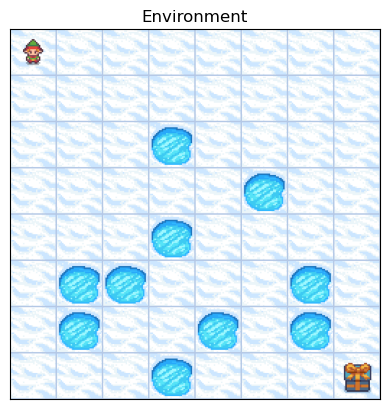

In [2]:
scale = 3
map_size = 2**scale
params: dict[str, Any] = dict(map_name=f"{map_size}x{map_size}", p=None, shape=(map_size,map_size), seed=42,)
env = frozen_lake.wrappers.TensorObservation(
    frozen_lake.wrappers.ReInitOnReset(frozen_lake.CustomFrozenLakeEnv(**params), **params),
    one_hot=True,
)
obs, info = env.reset()
print(f"Observation:\n {obs.shape, obs.dtype, obs.device}")
utils.render(env)

In [3]:
class AnnealingStrategy(NamedTuple):
    episodes: int
    epsilon: float

    def randomness(self, i: int) -> float:
        if i > self.episodes:
            return self.epsilon
        return 1.0 - (1.0 - self.epsilon) * i / self.episodes
        

class LazyConvEncoder(torch.nn.Sequential):
    def __init__(self, hidden, out):
        def cell(channels):
            return torch.nn.Sequential(
                torch.nn.LazyConv2d(channels, 3, padding=1),
                torch.nn.GELU(),
                torch.nn.LazyConv2d(channels, 2, stride=2),
                torch.nn.BatchNorm2d(channels),
            )

        super().__init__(
            *(cell(channels) for channels in hidden),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(out),
        )

In [4]:
from mango.mango import MangoEnv, Agent
from mango.policies.experiencereplay import ExperienceReplay
from mango.policies.dqnet import DQNetTrainer, DQNetPolicy

train_device = torch.device("cpu")
net = LazyConvEncoder(hidden=[2**scale]*scale, out=int(env.action_space.n)).eval()
policy = DQNetPolicy(net, env.action_space)
trainer = DQNetTrainer(net, lr=1e-3, gamma=0.95, tau=0.01)
replay = ExperienceReplay(256, capacity=2**13)
agent = Agent(MangoEnv(env), policy)

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
%%snakeviz -t
reward_log = []
lenght_log = []
loss_log = []
eval_reward_log = []

eval_interval = 10
episodes = 1000
annealing = AnnealingStrategy(episodes=episodes // 5, epsilon=0.2)
for i in tqdm(range(episodes)):
    # exploration
    trans = agent.run_episode(randomness = annealing.randomness(i))
    replay.extend(trans.steps)
    reward_log.append(trans.reward)
    lenght_log.append(len(trans.trajectory))
  
    # evaluation
    if i % eval_interval == 0:
        trans = agent.run_episode(randomness=0.0)
        eval_reward_log.extend([trans.reward] * eval_interval)

    # training
    if replay.can_sample():
        transitions = replay.sample(device=train_device)
        trainer.net.to(train_device, non_blocking=True)
        loss, td = trainer.train(transitions)
        replay.update_priorities_last_sampled(td)
        trainer.net.to("cpu", non_blocking=True)
        loss_log.append(loss)
    # if cuda syncronize to make sure all nets are back on cpu
    if torch.device.type == "cuda":
        torch.cuda.synchronize(train_device)

  0%|          | 0/1000 [00:00<?, ?it/s]

 
*** Profile stats marshalled to file 'C:\\Users\\dsart\\AppData\\Local\\Temp\\tmpuxs6wpmp'.
Opening SnakeViz in a new tab...


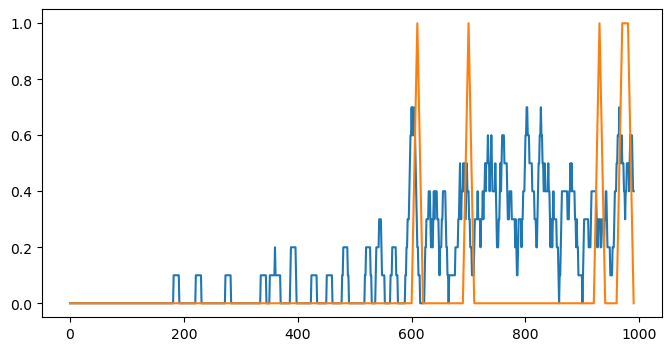

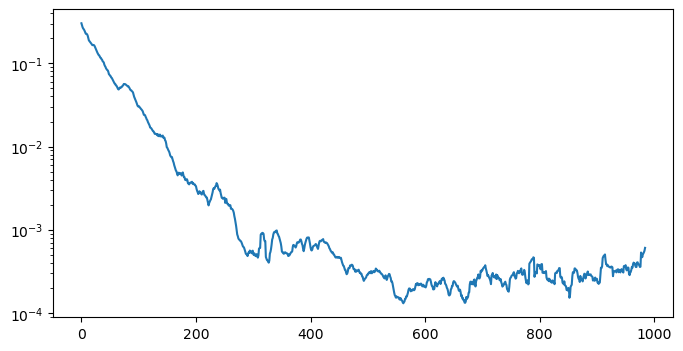

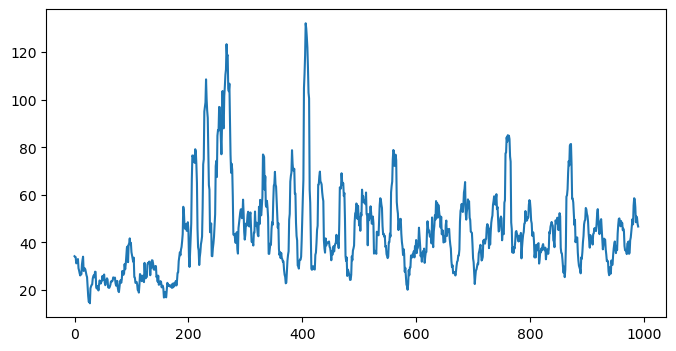

In [6]:
plt.figure(figsize=(8,4))
plt.plot(utils.smooth(reward_log))
plt.plot(utils.smooth(eval_reward_log))

plt.figure(figsize=(8,4))
plt.semilogy(utils.smooth(loss_log))
plt.figure(figsize=(8,4))
plt.plot(utils.smooth(lenght_log))

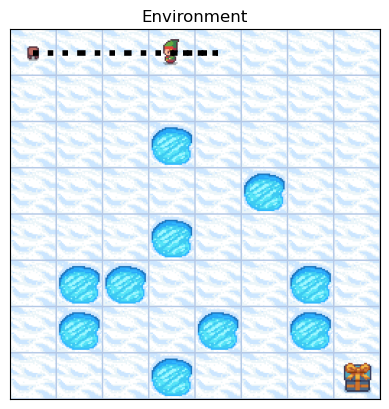

In [8]:
trans = agent.run_episode(randomness=0.0)
utils.render(env, trajectory=trans.trajectory)